# Uniswap V3 price analysis

In this notebook we will show how to download price events from Uniswap V3 to your computer as CSV files and use them to analyse price in each pool.

You will need to havev Ethereum JSON-RPC API node URL in order to pull out the data from Ethereum blockchain.
You will be interactively asked for this API key.

### Setup the notebook

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

from eth_defi.uniswap_v3.constants import UNISWAP_V3_FACTORY_CREATED_AT_BLOCK
from eth_defi.uniswap_v3.events import fetch_events_to_csv

### Download the raw data

For simplicity, you can sign up for free access to an Ethereum node for example at [Infura](https://infura.io/), however we recommend you to [run your own Ethereum node](https://tradingstrategy.ai/blog/preparing-a-server-for-hosting-goethereum-full-node).

In [20]:
# Get your node JSON-RPC URL
json_rpc_url = input("Please enter your Ethereum mainnet JSON-RPC URL here")

As an example, here we download raw events from first few blocks after Uniswap V3 was deployed.
The events will be stored in several CSV files at `/tmp` folder.

The scan will take hours. It can resumed on a crash, as we save the last scanned block in a JSON state file.

In [21]:
from eth_defi.event_reader.json_state import JSONFileScanState

start_block = UNISWAP_V3_FACTORY_CREATED_AT_BLOCK
end_block = UNISWAP_V3_FACTORY_CREATED_AT_BLOCK + 250_000

# Stores the last block number of event data we store
state = JSONFileScanState("/tmp/uniswap-v3-price-scan.json")

fetch_events_to_csv(json_rpc_url, state, start_block=start_block, end_block=end_block)

Restored previous scan state, data until block 12,456,621, we are skipping 87,000 blocks out of 250,000 total
Scanning block range 12,456,621 - 12,619,621


  0%|          | 0/163000 [00:00<?, ?it/s]

Wrote 1120 PoolCreated events
Wrote 830605 Swap events
Wrote 38605 Mint events
Wrote 33344 Burn events


### Analysing Uniswap v3 price formation

In Uniswap V3, you can get the current price of any pool from any given moment using swap events.

In [22]:
swap_df = pd.read_csv("/tmp/uniswap-v3-swap.csv")

Choose a pool to analyse, for example: USDC/ETH 0.3%.
You can find pool addresses [on Uniswap v3 info site](https://info.uniswap.org/#/).

In [23]:
pool_address = "0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8"

Extract only swaps related to this pool from the dataframe

In [24]:
df = swap_df[swap_df.pool_contract_address == pool_address]
df

,block_number,timestamp,tx_hash,log_index,pool_contract_address,amount0,amount1,sqrt_price_x96,liquidity,tick
19,12371376,2021-05-05T01:56:23,0xce7c3c307d820785caa12938012372fc9366a614a6aa...,26,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,1157920892373161954235709850086879078532699846...,100000000000000,1377932816571815120446551350158799,4303369674465501,195285
21,12373132,2021-05-05T08:23:26,0x9a1c51b0bffbf840948f3b6e3f3e495ba1cd3fa64854...,192,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,1157920892373161954235709850086879078532699846...,50000000000000000,1378850591292581266780357299649652,4303369674465501,195298
25,12373520,2021-05-05T09:50:51,0xc58715c62a5bf70a6ca09f0e51546d6cad76c8d4fff0...,8,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,1157920892373161954235709850086879078532699846...,100000000000000,1378852426842022799073024911548633,4303369674465501,195298
26,12374077,2021-05-05T11:59:57,0x288c21b8b4fbf449b1d086a06e43b124ac2bc088c3f5...,86,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,2,1157920892373161954235709850086879078532699846...,1378852426842016741051966412054516,4304946248093346,195298
45,12375770,2021-05-05T18:09:23,0xf76f19b991131f0f396f116f79215637dacad3cf5e1b...,249,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,1157920892373161954235709850086879078532699846...,300000000000000,1370242002332554394456531434422627,52976694435070763,195173
...,...,...,...,...,...,...,...,...,...,...
1229173,12619596,2021-06-12T12:16:13,0x8c1f6c5639b304eb0087c2b6d5b65e32ee4f1a51e8b0...,112,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,92432639474,1157920892373161954235709850086879078532699846...,1615736234513681125600943820478722,25998097729965548918,198469
1229192,12619598,2021-06-12T12:16:25,0xac8e34aa704a1ab4068bd93d4b5aef0fb7655d292fc9...,3,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,76760509615,1157920892373161954235709850086879078532699846...,1615639241428978886102798535892145,25997255949450154096,198468
1229194,12619598,2021-06-12T12:16:25,0x0752c6529f939f046c7f9648e8d27d76b1cf767d6902...,8,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,482579746068,1157920892373161954235709850086879078532699846...,1615029729696907486273078115160620,25997255949450154096,198460
1229198,12619598,2021-06-12T12:16:25,0xbd9193ff70e4828a43679f955c9707fa63fe1dabeed3...,45,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,679981136491,1157920892373161954235709850086879078532699846...,1614171674604720940565192048438458,25997255949450154096,198449


In Uniswap V3, we can get pool's price from pool's tick.

In [25]:
def tick_to_price(tick):
    return 1.0001**tick

df["price"] = df.apply(lambda row: tick_to_price(row["tick"]), axis=1)

/var/folders/tx/50wn88yd40v2_6_7fvfr98z00000gn/T/ipykernel_4254/3151975487.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["price"] = df.apply(lambda row: tick_to_price(row["tick"]), axis=1)


Then we can plot the price of this pool in first 1,000,000 blocks.

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.]),
 [Text(-10000.0, 0, '2021-06-03T13:37:08'),
  Text(0.0, 0, '2021-05-05T01:56:23'),
  Text(10000.0, 0, '2021-05-16T21:43:56'),
  Text(20000.0, 0, '2021-05-20T19:24:34'),
  Text(30000.0, 0, '2021-05-24T00:36:52'),
  Text(40000.0, 0, '2021-05-27T13:15:57'),
  Text(50000.0, 0, '2021-05-31T14:37:39'),
  Text(60000.0, 0, '2021-06-09T03:04:48'),
  Text(70000.0, 0, '')])

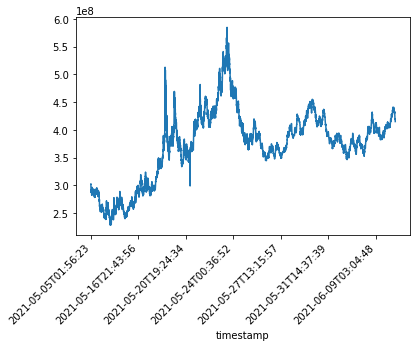

In [26]:
plt.rcParams["figure.dpi"] = 200

df.index = df.timestamp
df["price"].plot()

plt.xticks(rotation=45, ha="right")